# Compare ATL06-SR to CDEC snow depth
## Calculate:  
* #### median differences, 
* #### RMSE, 
* #### standard deviation

### Import necessary packages:

In [77]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import scipy.stats
from astropy.time import Time
import datetime
from rasterstats import zonal_stats
import pickle
from scipy import stats

In [78]:
%matplotlib inline

In [79]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '16'

In [80]:
pd.set_option('display.max_columns', None)

In [81]:
def iqr(x):
    IQR = stats.iqr(x, interpolation = 'midpoint', nan_policy='omit')
    return IQR

### Load the data:

In [82]:
atl06sr_gdf = pickle.load(open('../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed_bicubic_snowonaso.pkl', 'rb'))

outline_gdf = pickle.load(open('../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))

snwd = pickle.load(open('../data/CDEC/cdec_gdf.pkl', 'rb'))
cdec_geom = pickle.load(open('../data/CDEC/cdec_geometries.pkl', 'rb'))

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_896/4102051283.py:1: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  atl06sr_gdf = pickle.load(open('../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed_bicubic_snowonaso.pkl', 'rb'))
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_896/4102051283.py:3: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  outline_gdf = pickle.load(open('../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_896/4102051283.py:6: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  cdec_geom = pickle.load(open('../data/CDEC/cdec_geometries.pkl', 'rb'))


### Remove outliers:

In [83]:
atl06sr_gdf['zscore'] = (atl06sr_gdf['diff_plus_bicubic'] - atl06sr_gdf['diff_plus_bicubic'].mean()) / atl06sr_gdf['diff_plus_bicubic'].std()

zscore_thresh = 3
absdiff_thresh = 5.0

In [84]:
atl06_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & (atl06sr_gdf['diff_plus_bicubic'].abs() <= absdiff_thresh)

inner_snowoff_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus_bicubic'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 0)

inner_snowon_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus_bicubic'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 1)

In [85]:
atl06sr_gdf_inner = atl06sr_gdf[atl06_idx]

In [86]:
atl06sr_gdf['snow_presence'] = atl06sr_gdf['snow_presence'].astype(str).astype(int)

### Create a table of statistics for the ATL06-SR and CDEC data:

In [87]:
def make_comparison_table(df):
    comp_table_all = pd.DataFrame()
    comp_table_all.index = pd.DatetimeIndex(data=df['acqdate'].unique())
    comp_table_all['acqdate'] = comp_table_all.index.date
    
    # compute the median depth for each ATL06 date
    comp_table_all['median'] = ''
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'median'] = np.nanmedian(df.loc[df['acqdate']==date,'diff_plus_bicubic'])
    
    # compute the iqr for each ATL06 date
    comp_table_all['iqr'] = ''
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'iqr'] = iqr(df.loc[df['acqdate']==date,'diff_plus_bicubic'])
        
    comp_table_all['stdev'] = ''
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'stdev'] = np.std(df.loc[df['acqdate']==date,'diff_plus_bicubic'])
    
    # compute the sample size for each ATL06 date
    comp_table_all['n'] = ''
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'n'] = df.loc[df['acqdate']==date, 'diff_plus_bicubic'].count()
    
    # compute the depth on that day at the tuolumne meadows cdec pillow
    comp_table_all['tum_depth'] = ''
    for date in comp_table_all.index.to_pydatetime():
        comp_table_all.loc[comp_table_all.index==date,'tum_depth'] = snwd[snwd.index == date]['tum_m']
    
    # compute the depth on that day at the dana meadows cdec pillow
    comp_table_all['dan_depth'] = ''
    for date in comp_table_all.index.to_pydatetime():
        comp_table_all.loc[comp_table_all.index==date,'dan_depth'] = snwd[snwd.index == date]['dan_clean']
    
    # compute the difference between the atl06 median depth and the depth on that day at the dana meadows snow pillow
    comp_table_all['atl06-dan_diff'] = ''
    for date in comp_table_all.index.to_pydatetime():
        comp_table_all.loc[comp_table_all.index==date,'atl06-dan_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'dan_depth']
    
    # compute the difference between the atl06 median depth and the depth on that day at the tuolumne meadows snow pillow    
    comp_table_all['atl06-tum_diff'] = ''
    for date in comp_table_all.index.to_pydatetime():
        comp_table_all.loc[comp_table_all.index==date,'atl06-tum_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'tum_depth']
    
    # compute the mean of the tum and dan snow sensors on days with atl06 data
    comp_table_all['cdec_mean'] = np.nan
    for date in comp_table_all.index.to_pydatetime():
        comp_table_all.loc[comp_table_all.index==date,'cdec_mean'] = (comp_table_all.loc[comp_table_all.index==date,'tum_depth'] + comp_table_all.loc[comp_table_all.index==date,'dan_depth']) / 2
    
    # compute the difference between the atl06sr median depth and the average of the two cdec sites
    comp_table_all['atl06-cdec_mean'] = np.nan
    for date in comp_table_all.index.to_pydatetime():
        comp_table_all.loc[comp_table_all.index==date,'atl06-cdec_mean'] = ((comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'cdec_mean']))
    
    comp_table_all['rmse_tum'] = np.nan
    for date in comp_table_all.index:
        squared_dif = (df.loc[df.acqdate==date.date(), 'diff_plus_bicubic'] - comp_table_all.loc[comp_table_all.index==date,'tum_depth'][0])**2
        comp_table_all.loc[comp_table_all.acqdate==date.date(), 'rmse_tum'] = np.sqrt(np.nansum(squared_dif/squared_dif.count()))
        
    comp_table_all['rmse_dan'] = np.nan
    for date in comp_table_all.index:
        squared_dif = (df.loc[df.acqdate==date.date(), 'diff_plus_bicubic'] - comp_table_all.loc[comp_table_all.index==date,'dan_depth'][0])**2
        comp_table_all.loc[comp_table_all.acqdate==date.date(), 'rmse_dan'] = np.sqrt(np.nansum(squared_dif/squared_dif.count()))
    
    comp_table_all['mae_tum'] = np.nan
    for date in comp_table_all.index:
        abs_dif = abs(atl06sr_gdf.loc[atl06sr_gdf.acqdate==date.date(), 'diff_plus_bicubic'] - 
                                    comp_table_all.loc[comp_table_all.index==date,'tum_depth'][0])
        abs_dif_sum = np.nansum(abs_dif)
        n = abs_dif.count()
        if n != 0:
            comp_table_all.loc[comp_table_all['acqdate']==date.date(), 'mae_tum'] = abs_dif_sum/n
        else:
            comp_table_all.loc[comp_table_all['acqdate']==date.date(), 'mae_tum'] = np.nan
    
    comp_table_all['mae_dan'] = np.nan
    for date in comp_table_all.index:
        abs_dif = abs(atl06sr_gdf.loc[atl06sr_gdf.acqdate==date.date(), 'diff_plus_bicubic'] - 
                                    comp_table_all.loc[comp_table_all.index==date,'dan_depth'][0])
        abs_dif_sum = np.nansum(abs_dif)
        n = abs_dif.count()
        if n != 0:
            comp_table_all.loc[comp_table_all['acqdate']==date.date(), 'mae_dan'] = abs_dif_sum/n
        else:
            comp_table_all.loc[comp_table_all['acqdate']==date.date(), 'mae_dan'] = np.nan
    
    comp_table_all['snow_presence'] = 0
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'snow_presence'] = np.nanmean(df.loc[df['acqdate']==date.date(), 'snow_presence'])
    
    return comp_table_all

In [88]:
comp_df = make_comparison_table(atl06sr_gdf_inner)

In [89]:
comp_df.head()

,acqdate,median,iqr,stdev,n,tum_depth,dan_depth,atl06-dan_diff,atl06-tum_diff,cdec_mean,atl06-cdec_mean,rmse_tum,rmse_dan,mae_tum,mae_dan,snow_presence
2018-10-15,2018-10-15,-0.177437,0.981439,1.109608,893,0.0,-0.0254,-0.152037,-0.177437,-0.0127,-0.164737,1.125907,1.121880,0.808798,0.803603,0
2018-12-11,2018-12-11,0.465389,1.554263,1.439795,6010,0.6604,0.7112,-0.245811,-0.195011,0.6858,-0.220411,1.462085,1.471772,1.174246,1.182727,1
2019-01-09,2019-01-09,1.30759,1.172404,1.264032,60,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,1
2019-03-12,2019-03-12,2.485761,2.611059,1.866957,5081,2.4892,2.7178,-0.232039,-0.003439,2.6035,-0.117739,1.898121,1.952366,1.843126,1.823892,1
2019-04-10,2019-04-10,2.395167,1.201084,1.067347,2314,2.032,NaN,NaN,0.363167,NaN,NaN,1.118951,0.000000,0.959879,NaN,1


### Calculate some summary statistics:

In [95]:
np.nanmedian(comp_df.loc[comp_df['snow_presence']==1,'stdev'])

1.172449259999682

In [96]:
np.nanmedian(comp_df.loc[comp_df['snow_presence']==1,'atl06-tum_diff'])

-0.03384996259750947

In [97]:
np.nanmedian(comp_df.loc[comp_df['snow_presence']==1,'atl06-dan_diff'])

-0.4425697147877934

## Total RMSE

#### Compared to Tuolumne Meadows CDEC station (TUM):

In [98]:
squared_dif = np.sum((comp_df['median'] - comp_df['tum_depth'])**2)
rmse_all_tum = np.sqrt(squared_dif/comp_df['tum_depth'].count())
print('Basin RMSE tum:', rmse_all_tum)

Basin RMSE tum: 0.35444696367815803


In [99]:
squared_dif = np.sum((comp_df.loc[comp_df['snow_presence']==1,'median'] - comp_df.loc[comp_df['snow_presence']==1,'tum_depth'])**2)
rmse_all_snowon_tum = np.sqrt(squared_dif/comp_df.loc[comp_df['snow_presence']==1,'tum_depth'].count())
print('Basin RMSE snowon tum:', rmse_all_snowon_tum)

Basin RMSE snowon tum: 0.41591227648150286


#### Compared to Dana Meadows CDEC station (DAN):

In [100]:
squared_dif = np.sum((comp_df['median'] - comp_df['dan_depth'])**2)
rmse_all_dan = np.sqrt(squared_dif/comp_df['dan_depth'].count())
print('Basin RMSE dan:', rmse_all_dan)

Basin RMSE dan: 0.594193321066127


In [101]:
squared_dif = np.sum((comp_df.loc[comp_df['snow_presence']==1,'median'] - comp_df.loc[comp_df['snow_presence']==1,'dan_depth'])**2)
rmse_all_snowon_dan = np.sqrt(squared_dif/comp_df.loc[comp_df['snow_presence']==1,'dan_depth'].count())
print('Basin RMSE snowon dan:', rmse_all_snowon_dan)

Basin RMSE snowon dan: 0.8066795797809075


## MAE

In [102]:
abs_dif_sum = np.sum(abs(comp_df['median'] - comp_df['tum_depth']))
mae_all_tum = abs_dif_sum/comp_df['tum_depth'].count()
print('Basin MAE tum:', mae_all_tum)

Basin MAE tum: 0.23396680436316933


In [103]:
abs_dif_sum = np.sum(abs(comp_df['median'] - comp_df['dan_depth']))
mae_all_dan = abs_dif_sum/comp_df['dan_depth'].count()
print('Basin MAE dan:', mae_all_dan)

Basin MAE dan: 0.3911288264364369


## Create a table of statistics for data within the radii:

In [120]:
comp_tumradius = make_comparison_table(atl06sr_gdf_inner.loc[atl06sr_gdf_inner.within(cdec_geom.loc[2, 'geometry'])])

In [121]:
comp_tumradius = comp_tumradius.drop(columns=['dan_depth', 'atl06-dan_diff', 'rmse_dan', 'mae_dan'])

In [122]:
comp_tumradius.head()

,acqdate,median,iqr,stdev,n,tum_depth,atl06-tum_diff,cdec_mean,atl06-cdec_mean,rmse_tum,mae_tum,snow_presence
2019-04-10,2019-04-10,2.241086,1.199373,1.055368,1230,2.032,0.209086,NaN,NaN,1.083435,0.959879,1
2019-05-14,2019-05-14,1.020929,1.041129,0.996972,903,0.4064,0.614529,0.7747,0.246229,1.239992,1.615722,1
2019-07-09,2019-07-09,0.076921,0.60883,0.553336,123,0.0,0.076921,NaN,NaN,0.568982,0.617569,0
2019-12-11,2019-12-11,0.366468,0.732479,0.771137,131,0.7112,-0.344732,NaN,NaN,0.857708,1.056661,1
2020-01-07,2020-01-07,0.584082,0.664475,0.691107,1752,0.6858,-0.101718,NaN,NaN,0.696081,0.913841,1


In [117]:
comp_danradius = make_comparison_table(atl06sr_gdf_inner.loc[atl06sr_gdf_inner.within(cdec_geom.loc[3, 'geometry'])])

In [118]:
comp_danradius = comp_danradius.drop(columns=['tum_depth', 'atl06-tum_diff','rmse_tum', 'mae_tum'])

In [119]:
comp_danradius.head()

,acqdate,median,iqr,stdev,n,dan_depth,atl06-dan_diff,cdec_mean,atl06-cdec_mean,rmse_dan,mae_dan,snow_presence
2019-07-09,2019-07-09,-0.119576,0.348135,0.40716,67,NaN,NaN,NaN,NaN,0.000000,NaN,0
2019-12-11,2019-12-11,0.523721,1.229906,1.179557,1301,NaN,NaN,NaN,NaN,0.000000,NaN,1
2020-02-11,2020-02-11,0.71288,0.730012,0.697149,487,NaN,NaN,NaN,NaN,0.000000,NaN,1
2020-10-06,2020-10-06,-0.122425,0.417504,0.363563,26,0.0,-0.122425,0.0,-0.122425,0.367988,0.465007,0
2020-12-08,2020-12-08,0.734616,2.095692,1.638803,180,0.3556,0.379016,0.3048,0.429816,1.694200,1.348152,1


In [171]:
#comp_tumradius.to_csv('../../figures/comp_tumradius.csv')
#comp_danradius.to_csv('../../figures/comp_danradius.csv')

### Calculate some summary statistics:

In [123]:
np.nanmedian(comp_tumradius[comp_tumradius['snow_presence']==1]['atl06-tum_diff'])

-0.05681480213358148

In [126]:
np.nanmedian(comp_danradius[comp_danradius['snow_presence']==1]['atl06-dan_diff'])

-0.556679442057542

### Summary statistics for snow-on data only:

In [127]:
for data in [(comp_df[comp_df['snow_presence']==1]['iqr']), 
             comp_df[comp_df['snow_presence']==1]['atl06-tum_diff'], \
             #comp_df[comp_df['snow_presence']==1]['atl06-tum_percent'], 
             comp_df[comp_df['snow_presence']==1]['atl06-dan_diff'], \
            #comp_df[comp_df['snow_presence']==1]['atl06-dan_percent'], 
             comp_df[comp_df['snow_presence']==1]['stdev'],
             comp_tumradius[comp_tumradius['snow_presence']==1]['iqr'], \
            comp_tumradius[comp_tumradius['snow_presence']==1]['atl06-tum_diff'], 
             #comp_tumradius[comp_tumradius['snow_presence']==1]['atl06-tum_percent'], \
             comp_tumradius[comp_tumradius['snow_presence']==1]['stdev'],
            comp_danradius[comp_danradius['snow_presence']==1]['atl06-dan_diff'], 
             #comp_danradius[comp_danradius['snow_presence']==1]['atl06-dan_percent'], \
            comp_danradius[comp_danradius['snow_presence']==1]['iqr'],
            comp_danradius[comp_danradius['snow_presence']==1]['stdev']]:
    print(f'{data.name}', 'median =', np.nanmedian(data))

iqr median = 1.2010838174510354
atl06-tum_diff median = -0.03384996259750947
atl06-dan_diff median = -0.4425697147877934
stdev median = 1.172449259999682
iqr median = 0.7208514836236191
atl06-tum_diff median = -0.05681480213358148
stdev median = 0.729868021524552
atl06-dan_diff median = -0.556679442057542
iqr median = 0.7300124863284054
stdev median = 0.697148886724722


### Summary statistics for all data:

In [131]:
for data in [comp_df['iqr'], 
             comp_df['atl06-tum_diff'],  
             comp_df['atl06-dan_diff'],  
             comp_tumradius['iqr'], 
            comp_tumradius['atl06-tum_diff'], 
            comp_danradius['atl06-dan_diff'], 
            comp_danradius['iqr']]:
    print(f'{data.name}', 'median =', np.nanmedian(data))

iqr median = 1.1593251798681194
atl06-tum_diff median = -0.08500185489592074
atl06-dan_diff median = -0.14402061446150038
iqr median = 0.6786580680276302
atl06-tum_diff median = -0.10171760850565148
atl06-dan_diff median = -0.25452962857525563
iqr median = 0.7254105066040211


## RMSE Within Radius

In [132]:
squared_dif = np.sum((comp_tumradius['median'] - comp_tumradius['tum_depth'])**2)
rmse_radius_tum = np.sqrt(squared_dif/comp_tumradius['tum_depth'].count())
print('Radius RMSE tum:', rmse_radius_tum)

Radius RMSE tum: 0.23982400649366345


In [133]:
squared_dif = np.sum((comp_tumradius.loc[comp_tumradius['snow_presence']==1,'median'] - comp_tumradius.loc[comp_tumradius['snow_presence']==1,'tum_depth'])**2)
rmse_radius_snowon_tum = np.sqrt(squared_dif/comp_tumradius.loc[comp_tumradius['snow_presence']==1,'tum_depth'].count())
print('Radius RMSE snow on tum:', rmse_radius_snowon_tum)

Radius RMSE snow on tum: 0.28231251058340195


In [134]:
squared_dif = np.sum((comp_danradius['median'] - comp_danradius['dan_depth'])**2)
rmse_radius_dan = np.sqrt(squared_dif/comp_danradius['dan_depth'].count())
print('Radius RMSE dan:', rmse_radius_dan)

Radius RMSE dan: 0.581403239479639


In [135]:
squared_dif = np.sum((comp_danradius.loc[comp_danradius['snow_presence']==1,'median'] - comp_danradius.loc[comp_danradius['snow_presence']==1,'dan_depth'])**2)
rmse_radius_snowon_dan = np.sqrt(squared_dif/comp_danradius.loc[comp_danradius['snow_presence']==1,'dan_depth'].count())
print('Radius RMSE snow on dan:', rmse_radius_snowon_dan)

Radius RMSE snow on dan: 0.6205409137170795


## MAE Within Radius

In [136]:
abs_dif_sum = np.sum(abs(comp_tumradius['median'] - comp_tumradius['tum_depth']))
mae_radius_tum = abs_dif_sum/comp_tumradius['tum_depth'].count()
print('Radius MAE tum:', mae_radius_tum)

Radius MAE tum: 0.19945624423543973


In [137]:
abs_dif_sum = np.sum(abs(comp_danradius['median'] - comp_danradius['dan_depth']))
mae_radius_dan = abs_dif_sum/comp_danradius['dan_depth'].count()
print('Radius MAE dan:', mae_radius_dan)

Radius MAE dan: 0.4878368270539393


/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


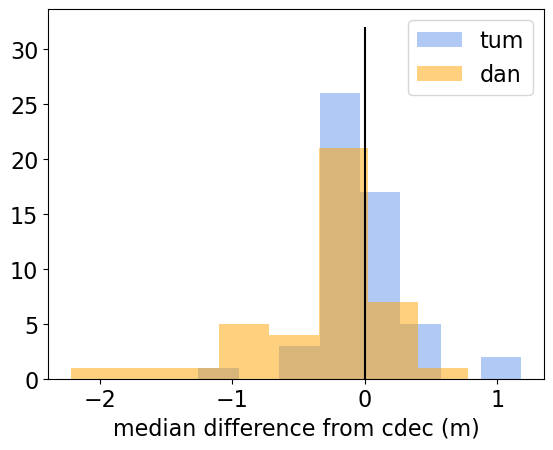

In [141]:
fig, ax = plt.subplots()
plt.hist(comp_df['atl06-tum_diff'], bins=round(np.sqrt(len(comp_df))), label='tum', alpha=0.5, color='cornflowerblue')
plt.hist(comp_df['atl06-dan_diff'], bins=round(np.sqrt(len(comp_df))), label='dan', alpha=0.5, color='orange')
plt.vlines(x=0, ymin=0, ymax=32, color='k')
plt.xlabel('median difference from cdec (m)')
#plt.ylabel('difference between \nATL06SR and CDEC')
plt.legend()